# Task

One of the hurdles of investing in cryptocurrencies is the high volatility of the asset class. There have been some research efforts done to model the volatility behaviour of the biggest asset - Bitcoin.

We would like you to review the current research results, comment on them, and propose a model that would be suitable for us to incorporate into our asset allocation model? If you have a better model than the researched ones, feel free to propose your recommendation (and code) as well. 

# Plans
1. Review some papers
1. Implement some models based on some papers, generate 1-step and 2-step ahead prediction to check their claims/conclusions .
1.  Final verdicts and extra comments
1. Future outlook

# Papers
- http://www.ukm.my/jsm/pdf_files/SM-PDF-49-3-2020/ARTIKEL%2025.pdf

# Q&A

1. Why is volatility forecasting important for asset allocations?
    - Volatility is widely accepted as a practical measure of risk.
    - To measure potential losses and make sound investment decisions, investors must estimate risks (volatility).
    - To provide a robust framework for the process of risk budgeting.
    - Inaccurate volatility estimates can leave financial institutions bereft of capital for operations and investment.
    
1. How volatility forecasting relates to asset allocation?
    - Volatility targeting and risk parity are asset allocation methodologies that are directly impacted by volatility forecasting.
    - The trade-off between return and risk is critical for all invesment decisions.
    - Asset allocation's aim is to control the overall fund returns within the desired range of volatility, as investors with different levels of risk tolerance and time horizons demand differentiated levels of volatility. 
    - Maintaining this range of volatility requires that a view to be taken on the expected future volatility for the asset classes in the fund.
    
1. What is risk parity allocation method?
    - Risk parity focused on the allocation of risk rather than the allocation of capital, assuming that each asset class contributes the same degree of volatility to the overall fund.
    
1. Why choose to predict volatility over returns?
    - Volatility possesses a number of stylised facts which make it inherently more predictable than returns.

1. What are some statistical properties of volatility?
    - volatility clustering
    - leverage effect
    - mean reversion
    - cross correlation of volatility

1. What is volatility clustering?
    - There is a delay for large or small changes in the absolute value of financial returns to revert back to mean levels.
    - The evidence for volatility clustering is shown by the positive autocorrelation in the absolute value of returns which eventually decays over time.
    - Observations of this type in financial time series go against simple random walk models and have led to the use of GARCH models and mean-reverting stochastic volatility models in financial forecasting. 

1. What are leverage effect and volatility feedback effect?
    - The leverage effect along with the volatility feedback effect describes the negative and asymmetric relationship between volatility and returns.
    - Leverage effect: negative returns induce higher subsequent volatility as compared to positive returns. A
    decrease in the value of a financial asset in the case of constant financial leverage makes the asset
    riskier and causes an increase in its volatility, which is termed the leverage effect.
    - Volatility feedback effect: volatility is priced and an increase in the volatility raises the required return on the underlying asset, which leads to an immediate stock price decline
    
1. Mean reversion
    - Volatility reverts to the mean over time. 
    - The half-life of volatility is measured as the time it takes volatility to move halfway towards its long-term mean.
    - Volatility has half-life of about 15-16 weeks based on AR models. 
    
1. Cross correlation of volatility
    - volatility is correlated across asset classes
    - correlation between the volatility of asset classes is stronger than that among the asset returns.
    
1. Methods of Volatility Forecasting
    - Historical volatility models
    - Random walk
    - Historical mean
    - Moving average (MA)
    - Exponentially weighted moving average (EWMA)
    - Discrete Historical Models
    - Autoregressive Moving Average (ARMA) models
    - ARCH models
    - Implied standard deviation models
    - Incorporation of Exogenous Factors/Variables
1. ARCH models
    - It has been observed that some periods in markets are riskier than the others, (i.e. there is a degree of latency or persistence in volatility) - volatility clustering.
    - Conditional heteroskedasticity refers to the notion that the next period's volatility is conditional on the volatility in the current period as well as to the time varying nature of volatility.
    - A simple ARCH model does not fully capture the persistence of volatility in a period of crisis. In this model, the next period's volatility is only conditional upon the last period's volatility.
    - GARCH was introduced to address this shortcoming. It is a way of specifying the dependence of the time varying nature of volatility.

In [195]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

# example of ARCH model
from random import gauss
from matplotlib import pyplot
from arch import arch_model


import pymc3 as pm

TypeError: 'numpy._DTypeMeta' object is not subscriptable

In [200]:
import pymc as pm

TypeError: 'numpy._DTypeMeta' object is not subscriptable

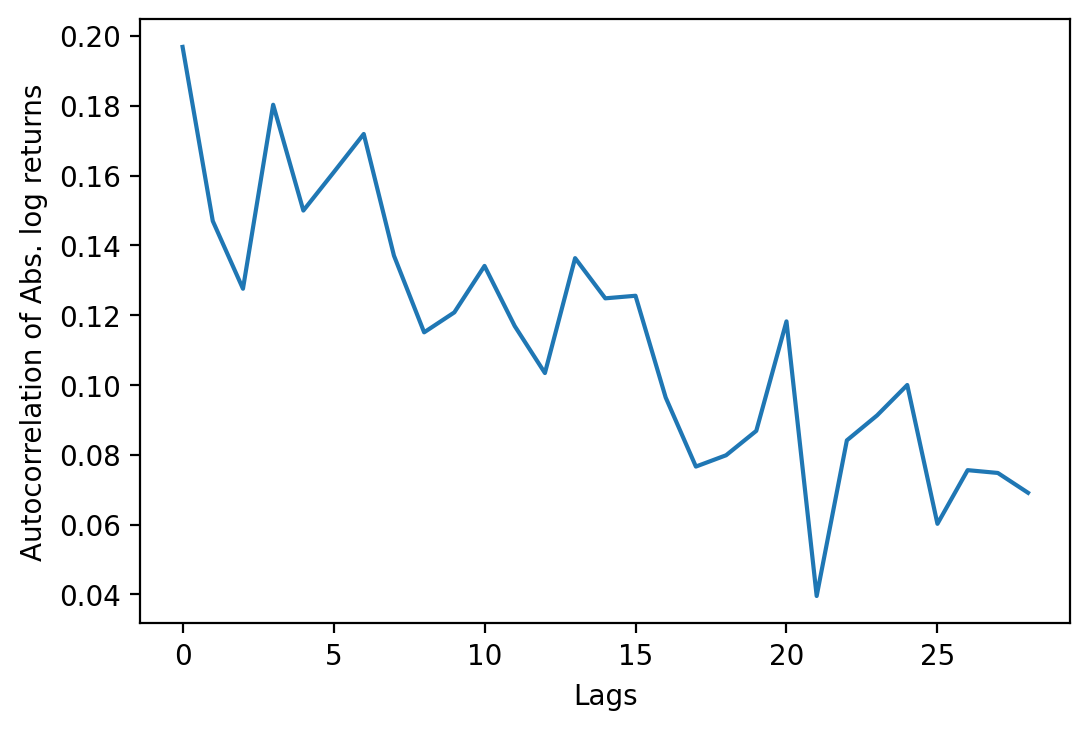

In [70]:
df = pd.read_csv("/Users/chunkiat/Downloads/BTC-USD.csv")
df["Date"] = pd.to_datetime(df["Date"])
df = df[["Date", "Close"]]
df.columns = ["date", "spot"]
# df = df[df["date"] > datetime(2018,1,1)].reset_index(drop = True)
df = df.resample('D', on='date').last().reset_index(drop = True)
df["log_ret"] = np.log(df["spot"]/df["spot"].shift(1))
df = df[df["log_ret"].notna()].reset_index(drop = True)

# Check for volatility clustering
df["abs_log_ret"] = abs(df["log_ret"])
auto_corr = []
for lags in range(1,30):
    auto_corr.append(np.corrcoef(df["abs_log_ret"][lags:], df["abs_log_ret"].shift(lags)[lags:])[0,1])

fig,ax = plt.subplots(1,1,dpi = 200)
ax.plot(auto_corr)
ax.set_xlabel("Lags")
ax.set_ylabel("Autocorrelation of Abs. log returns")
plt.plot()
plt.show()


# fig,ax = plt.subplots(1,1,dpi = 200)
# ax.plot(df["date"], df["spot"])
# ax.set_ylabel("USD")
# ax.set_xlabel("Time")
# plt.show()

Autocorrelation of absolute log returns decreases as lag increases. This shows the existence of volatility clustering. Hence we investigate the volatility forecasting ability of GARCH and Stochastic Volatility models.

## GARCH model

In [192]:
# Fit GARCH(1,1) model & do a recursive 1-step ahead forecast 
# (i.e. expand the observation sample after each 1-step forecast)
am = arch_model(df["log_ret"], vol="Garch", p=1, o=0, q=1, dist="Normal", rescale = True)

n_test = int(0.2*len(df))
train, test = df["log_ret"][:-n_test], df["log_ret"][-n_test:]

end_loc = len(train)
forecasts = {}
for i in range(1,n_test+1):
    res = am.fit(last_obs = i + end_loc, disp="off")
    scale = res.scale
    temp = res.forecast(horizon=1, reindex=False).variance
    fcast = temp.iloc[0]
    # Rescale the variance
    forecasts[fcast.name] = fcast/scale**2
    
predicted_variance = np.array(pd.DataFrame(forecasts).T["h.1"])
actual_variance = np.array(test**2)

# Compute MSE
mse = np.mean((predicted_variance - actual_variance)**2)
print(mse)


6.976028752689556e-06


2261   2020-11-26
2262   2020-11-27
2263   2020-11-28
2264   2020-11-29
2265   2020-11-30
          ...    
2821   2022-06-09
2822   2022-06-10
2823   2022-06-11
2824   2022-06-12
2825   2022-06-13
Name: date, Length: 565, dtype: datetime64[ns]

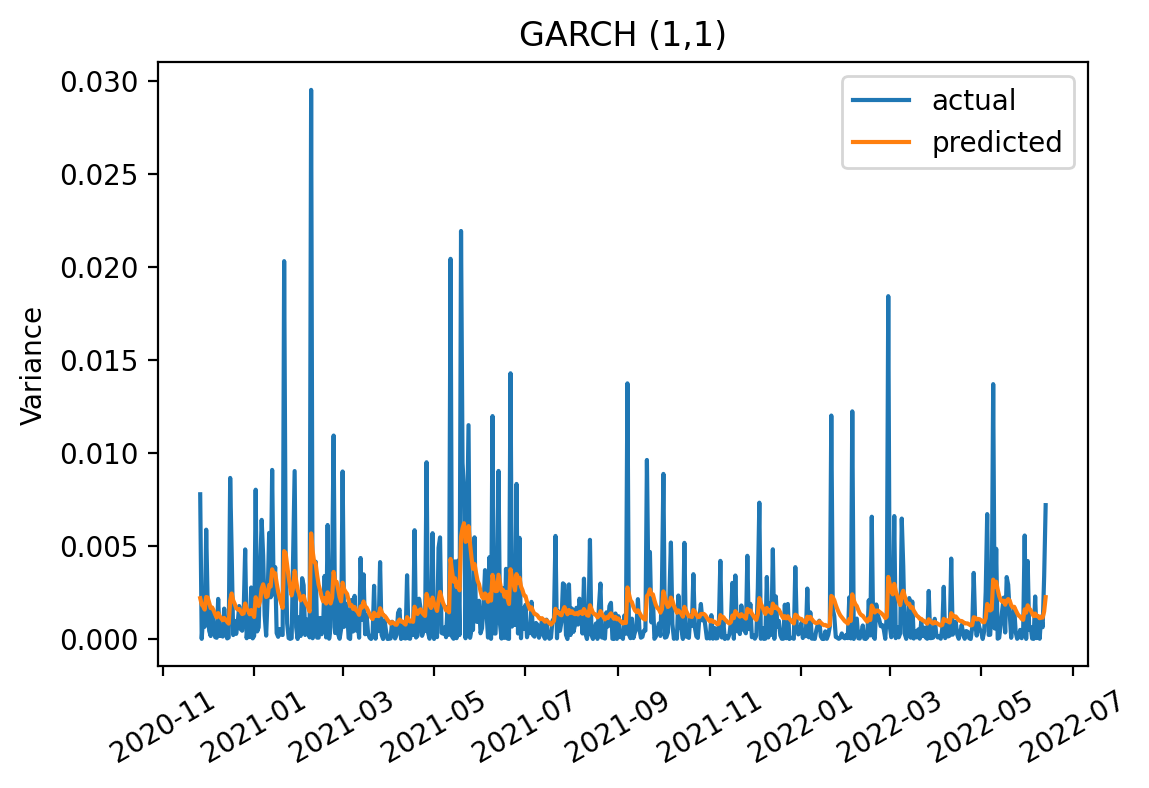

In [219]:
fig, ax = plt.subplots(1,1, dpi =200)
ax.plot(df.loc[test.index,:]['date'], actual_variance, label = "actual")
ax.plot(df.loc[test.index,:]['date'], predicted_variance, label = "predicted")
ax.set_title("GARCH (1,1)")
ax.set_ylabel("Variance")
ax.set_title("GARCH (1,1)")
ax.tick_params(axis='x', labelrotation = 30)
ax.legend()
plt.show()

## SV model